# KKBOX’s customer churn prediction

This notebook hosts the implementation code for the KKBOX customer churn prediction project. The project objective is to build a model that can accurately predict if a customer will churn from the service.

The dataset used is of customer demographic, transaction and usage information for one million KKBOX customers. KKBOX is Asia’s largest subscription based music streaming service, other companies similar to KKBOX are Spotify and Apple Music.  The dataset contains 25 features of demographic, transactional and usage data from the KKBOX app. A customer is said to have churned if they do not have a new valid service subscription within 30 days after their current subscription expires.

### Import python modules

In [0]:
import itertools
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib import pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import RobustScaler

from sklearn import tree
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from IPython.display import Image

## Load data as pandas dataframe

In [0]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# choose a local (colab) directory to store the data.
local_download_path = os.path.expanduser('~/ColabNotebook/data/')
try:
  os.makedirs(local_download_path)
except: pass

# 2. Auto-iterate using the query syntax
#    https://developers.google.com/drive/v2/web/search-parameters
file_list = drive.ListFile(
    {'q': "'14F-hzeJT0OehHFctfdSbZaTAZueokhND' in parents"}).GetList()

for f in file_list:
  # 3. Create & download by id.
  print('title: %s, id: %s' % (f['title'], f['id']))
  fname = os.path.join(local_download_path, f['title'])
  print('downloading to {}'.format(fname))
  f_ = drive.CreateFile({'id': f['id']})
  f_.GetContentFile(fname)


with open(fname, 'r') as f:
  dataset = 'trainfinal.csv'
  data = pd.read_csv(f)
features = [c for c in data.columns if c not in ['is_churn','msno']]

data_df, dropped_records, labels_df, dropped_features= train_test_split(data[features], data['is_churn'], test_size = 0.8, stratify=data['is_churn'])

data_df['is_churn'] = labels_df

title: trainfinal.csv, id: 1rpIzRPYqX0AlY8Kfpj_V2-AtpF_6TbFJ
downloading to /root/ColabNotebook/data/trainfinal.csv


## Exploratory Data Analysis


In [0]:
data_df.head()

,trans_count,days_listened,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,discount,is_discount,is_churn
364943,1.0,30.0,1.0,0.0,0.0,7.0,20160930.0,41.0,30.0,129.0,...,414.0,113.0,65.0,81.0,768.0,1192.0,228133.230,0.0,0,0
555844,1.0,30.0,13.0,0.0,2.0,9.0,20050624.0,34.0,30.0,149.0,...,156.0,10.0,18.0,17.0,656.0,722.0,172866.550,0.0,0,0
761055,1.0,8.0,15.0,24.0,2.0,7.0,20141128.0,36.0,30.0,180.0,...,40.0,10.0,7.0,3.0,117.0,159.0,31604.643,0.0,0,0
335265,2.0,3.0,18.0,26.0,2.0,9.0,20110524.0,39.0,30.0,149.0,...,3.0,3.0,0.0,0.0,1.0,7.0,593.065,0.0,0,0
47003,1.0,29.0,1.0,0.0,0.0,4.0,20160120.0,38.0,195.0,894.0,...,212.0,10.0,7.0,32.0,340.0,409.0,98824.586,0.0,0,1


In [0]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194192 entries, 364943 to 965106
Data columns (total 25 columns):
trans_count               194192 non-null float64
days_listened             194192 non-null float64
city                      194192 non-null float64
bd                        194192 non-null float64
gender                    194192 non-null float64
registered_via            194192 non-null float64
registration_init_time    194192 non-null float64
payment_method_id         194192 non-null float64
payment_plan_days         194192 non-null float64
plan_list_price           194192 non-null float64
actual_amount_paid        194192 non-null float64
is_auto_renew             194192 non-null float64
transaction_date          194192 non-null float64
membership_expire_date    194192 non-null float64
is_cancel                 194192 non-null float64
num_25                    194192 non-null float64
num_50                    194192 non-null float64
num_75                    194192 n

In [0]:
data_df.describe()

,trans_count,days_listened,city,bd,gender,registered_via,registration_init_time,payment_method_id,payment_plan_days,plan_list_price,...,num_25,num_50,num_75,num_985,num_100,num_unq,total_secs,discount,is_discount,is_churn
count,194192.000000,194192.000000,194192.000000,194192.000000,194192.000000,194192.000000,1.941920e+05,194192.000000,194192.000000,194192.000000,...,194192.000000,194192.000000,194192.000000,194192.000000,194192.00000,194192.000000,1.941920e+05,194192.000000,194192.000000,194192.000000
mean,1.167386,13.937315,5.259439,12.017040,0.589504,6.108125,1.785552e+07,37.397498,32.561959,139.348830,...,84.343433,20.415743,12.855725,14.602162,416.02013,397.796413,1.086485e+05,0.167185,0.001643,0.089942
std,1.329616,11.338582,6.345965,20.006828,0.787995,2.845297,6.376654e+06,8.355939,33.289830,140.418809,...,164.228056,36.025448,20.802348,48.261674,703.25891,569.873054,1.733243e+05,4.728912,0.040497,0.286099
min,0.000000,0.000000,0.000000,-2828.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000e+00,-1.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,0.000000,0.000000,4.000000,2.010112e+07,37.000000,30.000000,99.000000,...,1.000000,0.000000,0.000000,0.000000,5.00000,9.000000,1.793996e+03,0.000000,0.000000,0.000000
50%,1.000000,14.000000,1.000000,0.000000,0.000000,7.000000,2.013113e+07,41.000000,30.000000,149.000000,...,32.000000,8.000000,5.000000,6.000000,181.00000,202.000000,4.983134e+04,0.000000,0.000000,0.000000
75%,1.000000,25.000000,11.000000,26.000000,1.000000,7.000000,2.015121e+07,41.000000,30.000000,149.000000,...,103.000000,26.000000,17.000000,18.000000,527.00000,552.000000,1.411933e+05,0.000000,0.000000,0.000000
max,148.000000,31.000000,22.000000,1970.000000,2.000000,13.000000,2.017042e+07,41.000000,450.000000,1788.000000,...,25663.000000,2129.000000,626.000000,15164.000000,30935.00000,23403.000000,7.746371e+06,180.000000,1.000000,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


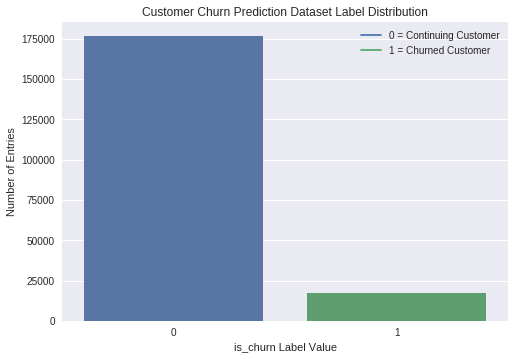

In [0]:
sns.countplot(data_df['is_churn'])
pyplot.plot(0, label ="0 = Continuing Customer")
pyplot.plot(1, label ="1 = Churned Customer")
pyplot.xlabel("is_churn Label Value")
pyplot.ylabel("Number of Entries")
pyplot.title("Customer Churn Prediction Dataset Label Distribution")
pyplot.legend()
pyplot.savefig('churn_label_skew.png')
pyplot.show()

Observations:

- The dataset contains 25 features of demographic, transactional and usage data from the KKBOX app.
- All features contain numeric data with no null-values
- The dataset is a relatively large and heavily skewed , only a small percent of the customers in the dataset   are labeled as chruned

## Training, Testing, Validation Set Split

50% training, 50% testing

In [0]:

train_X, test_X, train_y, test_y = train_test_split(data_df[features], data_df['is_churn'], test_size = 0.7, stratify=data_df['is_churn'])

## Preproccessing (Normalization)

In [0]:
preproccess = RobustScaler()
preproccess.fit(train_X)
train_X = preproccess.transform(train_X)
test_X = preproccess.transform(test_X)

## Decision Trees

Decision Trees are a supervised learning method that is used for classification. It attempts to effiently filter input features using a series of simple rule based splits inorder to identify the correct output label. One way to select the best feature and/or threshold to split the data is by constantly selecting the split that will maximize information gain in a divide and conquer fashion.

### Hyper-parameter tuning

First, several decision tree classifiers were built with various settings of the maximum tree depth hyper-parameter. The figure shows the AUC estimate of the decision tree models with varying tree depth. It can be seen that during training as the tree depth increases the model performance also increases; however, during testing a cutoff tree depth can be observed where the model performance stops improving and starts to decrease. The models to the left of the cutoff are said to be underfitted models that do not predict efficiently because they all excessively simple architecture. One the other hand, models to the right of the cutoff are said to be overfitted models that so do not predict most efficiently because they tailored too much to their own training set.

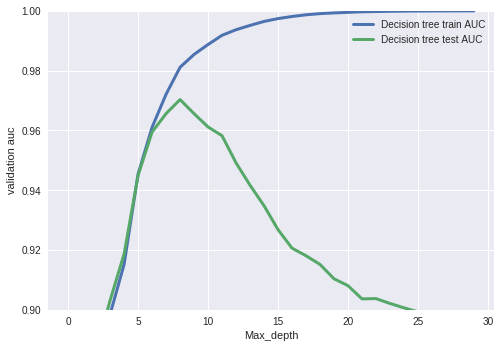

<Figure size 864x864 with 0 Axes>

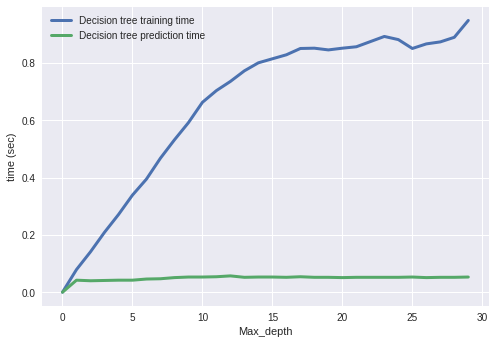

<Figure size 864x864 with 0 Axes>

In [0]:
max_depth = 30
tree_auc_train, tree_auc_test = np.zeros(max_depth), np.zeros(max_depth)
training_time, prediction_time = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1,max_depth):
    clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
    t0=time.clock()
    clf_decision_tree = clf_decision_tree.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    tree_auc_train[i] = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
    t1=time.clock()
    tree_auc_test[i] = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])
    prediction_time[i] = round(time.clock()-t1, 3)


from matplotlib import pyplot
pyplot.plot(tree_auc_train, linewidth=3, label = "Decision tree train AUC")
pyplot.plot(tree_auc_test, linewidth=3, label = "Decision tree test AUC")
pyplot.legend()
pyplot.ylim(0.9, 1.0)
pyplot.xlabel("Max_depth")
pyplot.ylabel("validation auc")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_treedepth_fig2')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Decision tree training time")
pyplot.plot(prediction_time, linewidth=3, label = "Decision tree prediction time")
pyplot.legend()
pyplot.xlabel("Max_depth")
pyplot.ylabel("time (sec)")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_treedepth_time_fig2')
pyplot.show()


In [0]:
print("Best tree depth training: " + str(np.argmax(tree_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(tree_auc_train, axis=0)))
print("Best tree depth testing: " + str(np.argmax(tree_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(tree_auc_test, axis=0)))

Best tree depth training: 29
Highest AUC score training: 0.9999883283152589
Best tree depth testing: 8
Highest AUC score testing: 0.9703112291100575


### Decision tree pruning

After the optimal tree depth parameter was identified, A decision tree classifier with that depth was built for each dataset and then each of the trees was pruned to analyze the how that can affect the classification performance.

Tree pruning is reducing the size of a decision tree by removing sections of the tree that provide little power to classify samples. It reduces the complexity of the final classifier, and hence improves predictive accuracy by the reduction of overfitting.

Table 1 shows the AUC estimates of the decision tree classifier before and after pruning. It can be seen that that tree pruning had little effect on the classification performance. One possible expiation for the lack of significant performance improvement is that optimizing the tree depth parameter could be seen an indirect form of tree pruning since limiting tree depth also means limiting the number of duplicate leaves.

In [0]:
from sklearn.tree._tree import TREE_LEAF

def is_leaf(inner_tree, index):
    # Check whether node is leaf node
    return (inner_tree.children_left[index] == TREE_LEAF and 
            inner_tree.children_right[index] == TREE_LEAF)

def prune_index(inner_tree, decisions, index=0):
    # Start pruning from the bottom - if we start from the top, we might miss
    # nodes that become leaves during pruning.
    # Do not use this directly - use prune_duplicate_leaves instead.
    if not is_leaf(inner_tree, inner_tree.children_left[index]):
        prune_index(inner_tree, decisions, inner_tree.children_left[index])
    if not is_leaf(inner_tree, inner_tree.children_right[index]):
        prune_index(inner_tree, decisions, inner_tree.children_right[index])

    # Prune children if both children are leaves now and make the same decision:     
    if (is_leaf(inner_tree, inner_tree.children_left[index]) and
        is_leaf(inner_tree, inner_tree.children_right[index]) and
        (decisions[index] == decisions[inner_tree.children_left[index]]) and 
        (decisions[index] == decisions[inner_tree.children_right[index]])):
        # turn node into a leaf by "unlinking" its children
        inner_tree.children_left[index] = TREE_LEAF
        inner_tree.children_right[index] = TREE_LEAF
        print("Pruned {}".format(index))

def prune_duplicate_leaves(mdl):
    # Remove leaves if both 
    decisions = mdl.tree_.value.argmax(axis=2).flatten().tolist() # Decision for each node
    prune_index(mdl.tree_, decisions)

# plot_tree(clf, features)
# tree.export_graphviz(clf,out_file='tree.dot',class_names=['No','Yes'],feature_names=features, 
#                      filled=True, rounded=True, special_characters=True, proportion=True)
# os.system("dot -Tpng tree.dot -o tree.png")
# os.system("tree.png")
# # Note : Uncoverted Quotes (Yes) and Converted quotes (No)
# Image(filename='tree.png')


clf_decision_tree = tree.DecisionTreeClassifier(max_depth=i, criterion='entropy',random_state=1)
clf_decision_tree = clf_decision_tree.fit(train_X, train_y)
prune_duplicate_leaves(clf_decision_tree)
    
tree_auc_train_pruned = roc_auc_score(train_y, clf_decision_tree.predict_proba(train_X)[:,1])
tree_auc_test_pruned = roc_auc_score(test_y, clf_decision_tree.predict_proba(test_X)[:,1])

print("pruned decision tree training: " + str(tree_auc_train_pruned))
print("pruned decision tree testing: " + str(tree_auc_test_pruned))

# plot_tree(clf, features)
# tree.export_graphviz(clf,out_file='tree_pruned.dot',class_names=['No','Yes'],feature_names=features, 
#                          filled=True, rounded=True, special_characters=True, proportion=True)
# os.system("dot -Tpng tree_pruned.dot -o tree_pruned.png")
# os.system("tree_pruned.png")
# # Note : Uncoverted Quotes (Yes) and Converted quotes (No)
# Image(filename='tree_pruned.png')


Pruned 61
Pruned 60
Pruned 59
Pruned 68
Pruned 1022
Pruned 1025
Pruned 1021
Pruned 1585
Pruned 1818
Pruned 2144
Pruned 2143
pruned decision tree training: 0.9999778426968622
pruned decision tree testing: 0.8960072182345329


## Boosting

Gradient boosting produces a prediction model in the form of an ensemble of weak learning prediction models. It builds all the weak learning models in a stage-wise fashion and assigns a weight to each of them. Then that weight is optimized by comparing the predicted results to the actual labels and then modifying the model weights using a loss function.

The boosting algorithm that was implemented for this analysis was the Adaboosting algorithm and the weak learning that was selected was the pruned decision tree that produced the best performance in the decision tree section.

### Hyperparameter tuning.

For a boosting algorithm, the main parameters to explore are the type and number of weak learners the algorithm is built with. Since an optimized weak learning model has already been analyzed and selected in the decision tree section, only the effect of varying number of weak learners on the performance of the boosting algorithm was a studied.

The figure shows the AUC estimate of the adaboosting models with various numbers of weak learners.  It can be seen that during training as the number of weak learners increases the model performance also increases; however, during testing a cutoff number of weak learners can be observed where the model performance stops improving and starts to show signs of overfitting similar to what was observed in the previous section. 

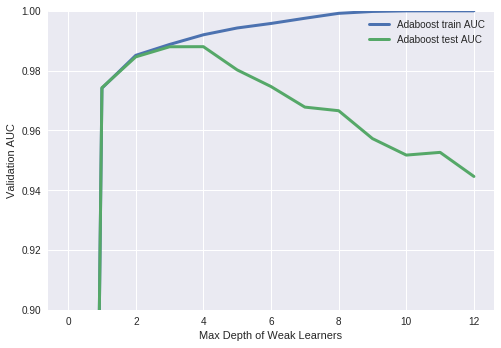

<Figure size 864x864 with 0 Axes>

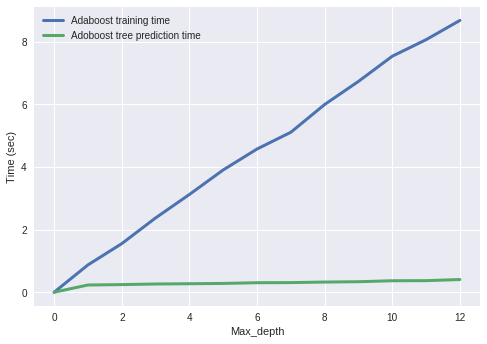

<Figure size 864x864 with 0 Axes>

Best weak learner tree depth training: 29
Highest AUC score training: 0.9999883283152589
Best weak learner tree depth testing: 8
Highest AUC score testing: 0.9703112291100575


In [0]:
max_depth = 13
adaboost_auc_train, adaboost_auc_test = np.zeros(max_depth), np.zeros(max_depth)
training_time, prediction_time = np.zeros(max_depth), np.zeros(max_depth)
for i in range(1,max_depth):
    clf_adaboost = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=i,criterion='entropy'), n_estimators=10, random_state=1)
    t0 = time.clock()
    clf_adaboost = clf_adaboost.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    adaboost_auc_train[i] = roc_auc_score(train_y, clf_adaboost.predict_proba(train_X)[:,1])
    t1 = time.clock()
    adaboost_auc_test[i] = roc_auc_score(test_y, clf_adaboost.predict_proba(test_X)[:,1])
    prediction_time[i] = round(time.clock()-t1, 3)
    
pyplot.plot(adaboost_auc_train, linewidth=3, label = "Adaboost train AUC")
pyplot.plot(adaboost_auc_test, linewidth=3, label = "Adaboost test AUC")
pyplot.legend()
pyplot.ylim(0.9, 1.0)
pyplot.xlabel("Max Depth of Weak Learners")
pyplot.ylabel("Validation AUC")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_boosting_fig4')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Adaboost training time")
pyplot.plot(prediction_time, linewidth=3, label = "Adoboost tree prediction time")
pyplot.legend()
pyplot.xlabel("Max_depth")
pyplot.ylabel("Time (sec)")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_boosting_time_fig2')
pyplot.show()

print("Best weak learner tree depth training: " + str(np.argmax(tree_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(tree_auc_train, axis=0)))
print("Best weak learner tree depth testing: " + str(np.argmax(tree_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(tree_auc_test, axis=0)))

## Neural Networks

A neural network is a supervised machine learning method that is roughly based on neural connections in biological entities. In its most simple form, input data features are fed into one end of the network where, at each node, they multiplied by an assigned weight value and passed through a certain simple function, called an activation function. This process is then repeated for some number of layers of nodes to form complex logic functions that attempt to describe the training input to labels mapping. The final layer of the network is the output layer where the final classification is produced. During training the network output classification is compared to the true label and then all the weights throughout the entire networks is adjusted based on some calculated loss value. 

The process of passing instance data through a neural network from the input to the output layers as described above is called feedforwarding and the process of calculating the loss value at the output layer side and adjusting the assigned network weights all way back to the input layer is called backpropagation.

The neural network built for this analysis is a simple network consisting of only 3 layers. An input layer, one hidden layer and an output layer. The initial network weights are assigned randomly and the activation function at each network node is the ReLu function. For calulating the loss …….. Is used and a method called gradient decent is employed where ……

### Hyperparameter tuning

Since neural networks are highly modular, a large number of architectures can possibly be explored along with their own hyperparameters. For this analysis only the affects of varying the learning rate parameter was analyzed

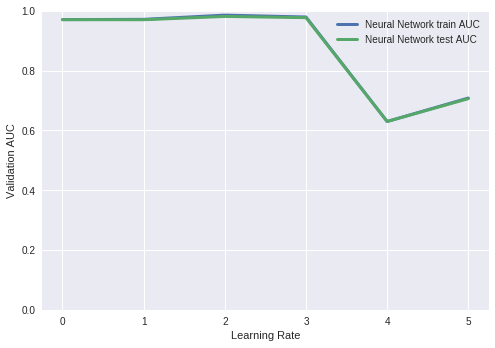

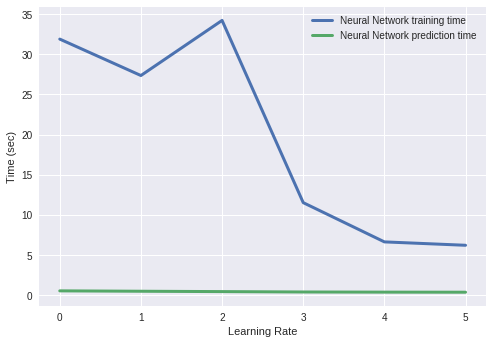

<Figure size 864x864 with 0 Axes>

Best earning rate training: 2
Highest AUC score training: 0.9855959783603906
Best learning rate testing: 2
Highest AUC score testing: 0.981228367045978


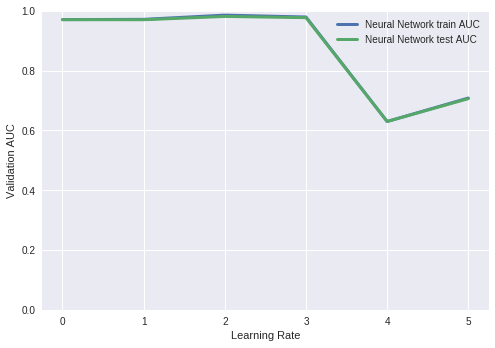

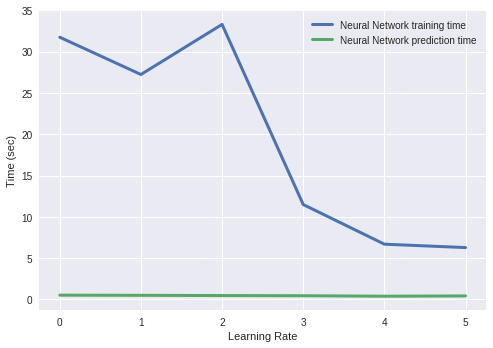

<Figure size 864x864 with 0 Axes>

Best earning rate training: 2
Highest AUC score training: 0.9855959783603906
Best learning rate testing: 2
Highest AUC score testing: 0.981228367045978


In [0]:
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1, 10]
training_time, prediction_time = [],[]
nn_auc_train, nn_auc_test = [],[]
for rate in learning_rate:
    clf_nn = MLPClassifier(learning_rate_init=rate, random_state=1)
    t0 = time.clock()
    clf_nn = clf_nn.fit(train_X, train_y)
    training_time.append(round(time.clock()-t0, 3))
    nn_auc_train.append(roc_auc_score(train_y, clf_nn.predict_proba(train_X)[:,1]))
    t1 = time.clock()
    nn_auc_test.append(roc_auc_score(test_y, clf_nn.predict_proba(test_X)[:,1]))
    prediction_time.append(round(time.clock()-t1, 3))

pyplot.plot(nn_auc_train, linewidth=3, label = "Neural Network train AUC")
pyplot.plot(nn_auc_test, linewidth=3, label = "Neural Network test AUC")
pyplot.legend()
pyplot.ylim(0.0, 1.0)
pyplot.xlabel("Learning Rate")
pyplot.ylabel("Validation AUC")
pyplot.savefig('churn_neural_network_fig')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "Neural Network training time")
pyplot.plot(prediction_time, linewidth=3, label = "Neural Network prediction time")
pyplot.legend()
pyplot.xlabel("Learning Rate")
pyplot.ylabel("Time (sec)")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_nn_time_fig')
pyplot.show()

print("Best earning rate training: " + str(np.argmax(nn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(nn_auc_train, axis=0)))
print("Best learning rate testing: " + str(np.argmax(nn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(nn_auc_test, axis=0)))

## k-Nearest Neighbors

K- nearest neighbors is another supervised machine learning method that is used for classification. Unlike all the other methods discussed in this analysis that are ……learning methods, k-nearest neighbors is an instance-based learning method, also called a lazy learning method. Instead of attempting find a function/method that maps the all the input training instances to their correct labels instance based learners attempt to classify instances solely based on the classification of the most similar instance in the true labeled training set. In K-NN an instance in classified based on the labels of the “K” closet neighboring training instances to it.

Compared to ….. learning methods, instance based learning is trained much faster, however, prediction time is slower because most of the algorithm computations are pushed to the prediction phase instead of the learning phase, hence the term “lazy” learner.

### Hyperparameter tuning.

The prediction results of a K-NN algorithm can be heavily dependent of the parameters selected. For this reason, domain knowledge is preferred when using this type of classifier. For this analysis, the minimum numbers of neighbors required to classify an entry was analyzed was well as the type of distance calculation used to calculate the those K neighbors. All neighbors were given equal importance weights and ………

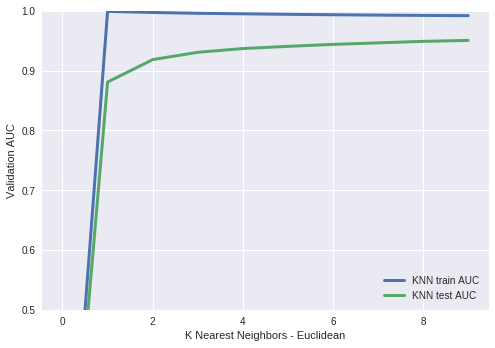

<Figure size 864x864 with 0 Axes>

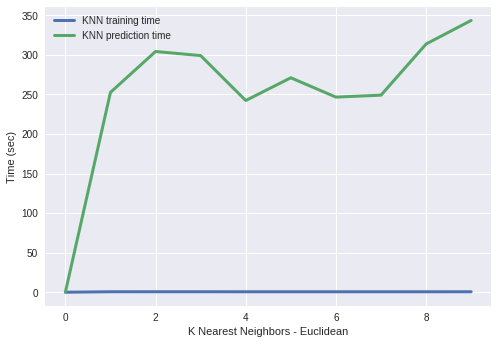

<Figure size 864x864 with 0 Axes>

Best number of neighbors training: 1
Highest AUC score training: 0.9990374810643338
Best number of neighbors testing: 9
Highest AUC score testing: 0.9505031211162894


In [0]:
max_k = 10
knn_auc_train, knn_auc_test = np.zeros(max_k), np.zeros(max_k)
training_time, prediction_time = np.zeros(max_k), np.zeros(max_k)
for i in range(1,max_k):
    clf_knn = KNeighborsClassifier(n_neighbors=i, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
    t0 = time.clock()
    clf_knn = clf_knn.fit(train_X, train_y)
    training_time[i] = round(time.clock()-t0, 3)
    pred_train = clf_knn.predict_proba(train_X)[:,1]
    t1 = time.clock()
    pred_test = clf_knn.predict_proba(test_X)[:,1]
    prediction_time[i] = round(time.clock()-t1, 3)
    knn_auc_train[i] = roc_auc_score(train_y, pred_train)
    knn_auc_test[i] = roc_auc_score(test_y, pred_test)

pyplot.plot(knn_auc_train, linewidth=3, label = "KNN train AUC")
pyplot.plot(knn_auc_test, linewidth=3, label = "KNN test AUC")
pyplot.legend()
pyplot.ylim(0.5, 1.0)
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Validation AUC")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_knn_fig6')
pyplot.show()

pyplot.plot(training_time, linewidth=3, label = "KNN training time")
pyplot.plot(prediction_time, linewidth=3, label = "KNN prediction time")
pyplot.legend()
pyplot.xlabel("K Nearest Neighbors - Euclidean")
pyplot.ylabel("Time (sec)")
pyplot.figure(figsize=(12,12))
pyplot.savefig('churn_Knn_time_fig')
pyplot.show()

print("Best number of neighbors training: " + str(np.argmax(knn_auc_train, axis=0)))
print("Highest AUC score training: " + str(np.max(knn_auc_train, axis=0)))
print("Best number of neighbors testing: " + str(np.argmax(knn_auc_test, axis=0)))
print("Highest AUC score testing: " +  str(np.max(knn_auc_test, axis=0)))


    
    

## Support Vector Machines (SVM)

In [0]:
clf_svm_linear = SVC(kernel='linear',probability=True, random_state=1)
t0 = time.clock()
clf_svm_linear.fit(train_X, train_y)
training_time_linear = round(time.clock()-t0, 3)
pred_train_linear = clf_svm_linear.predict_proba(train_X)[:,1]
t1 = time.clock()
pred_test_linear = clf_svm_linear.predict_proba(test_X)[:,1]
prediction_time_linear = round(time.clock()-t1, 3)
svm_auc_train_linear = roc_auc_score(train_y, pred_train_linear)
svm_auc_test_linear = roc_auc_score(test_y, pred_test_linear)

clf_svm_rbf = SVC(kernel='rbf',probability=True, random_state=1)
t0 = time.clock()
clf_svm_rbf.fit(train_X, train_y)
training_time_rbf = round(time.clock() - t0, 3)
pred_train_rbf = clf_svm_rbf.predict_proba(train_X)[:,1]
t1= time.clock()
pred_test_rbf = clf_svm_rbf.predict_proba(test_X)[:,1]
prediction_time_rbf = round(time.clock() - t1, 3)
svm_auc_train_rbf = roc_auc_score(train_y, pred_train_rbf)
svm_auc_test_rbf = roc_auc_score(test_y, pred_test_rbf)

print("Linear kernel training AUC: " + str(svm_auc_train_linear))
print("Linear kernel testing AUC: " + str(svm_auc_test_linear))
print("rbf kernel training AUC: " + str(svm_auc_train_rbf))
print("rbf kernel testing AUC: " + str(svm_auc_test_rbf))

print("Linear kernel training time: " + str(training_time_linear))
print("Linear kernel prediction tim: " + str(prediction_time_linear))
print("rbf kernel training time: " + str(training_time_rbf))
print("rbf kernel prediction tim: " + str(prediction_time_rbf))
                             


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Linear kernel training AUC: 0.9321092384741348
Linear kernel testing AUC: 0.9337428074443875
rbf kernel training AUC: 0.9732192032744215
rbf kernel testing AUC: 0.9584828695091383
Linear kernel training time: 1527.648
Linear kernel prediction tim: 8.981
rbf kernel training time: 645.705
rbf kernel prediction tim: 41.061


In [0]:
## Model Comparison

In [0]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

X, y = train_X, train_y


title = "Learning Curves (Decision Tree)"
estimator = tree.DecisionTreeClassifier(max_depth=8, criterion='entropy',random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()
title = "Learning Curves (Adaboost)"
estimator = AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(max_depth=8,criterion='entropy'), n_estimators=10,random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()
title = "Learning Curves (Neural Network)"
estimator = MLPClassifier()
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()
title = "Learning Curves (K-NN)"
estimator = KNeighborsClassifier(n_neighbors=1, algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, p=2, weights='uniform')
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

title = "Learning Curves (SVM)"
estimator = SVC(kernel='linear',probability=True, random_state=1)
plot_learning_curve(estimator, title, X, y, cv=None, n_jobs=-1)

plt.show()
